# Quality of drought indicators

This script is using a sample from the ERA5--Drought data set from the European Centre for Medium-range Weather Forecasts (ECMWF) and plots the quality of the dataset. 
The output of this notebook is published as Figure 3 in 
> Keune, J., F. Di Giuseppe, C. Barnard, E. Damasio da Costa, and F. Wetterhall (XXXX): \textbf{ERA5--Drought: Global drought indicators based on ECMWF reanalysis}, submitted to Scientific Data. 

## Setup & Settings

#### Load libraries

In [1]:
import os 
import sys
import netCDF4 as nc4
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string

#### Plot settings

In [2]:
mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']
legnames     = ["masked","extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet"]

In [3]:
spi_configs = {
    'distribution'   : ['gamma'],
    'windows'        : [1, 3, 6, 12, 24, 36, 48],
    'colors'         : ['023047']}
spei_configs = {
    'distribution'   : ['genlogistic'],
    'windows'        : [1, 3, 6, 12, 24, 36, 48],
    'colors'         : ['219ebc']}

#### Some helpful functions

In [4]:
def hex2rgb(hexs):
   return tuple(int(hexs[i:i+2], 16)/255 for i in (0, 2, 4))

In [5]:
def acceptance_rate_monthly_masked(xrdata_3d, mask_3d):
    notvalid      = xr.where(np.isnan(xrdata_3d), 1, 0).sum(axis=(1,2)).values
    significant   = xr.where(xrdata_3d*mask_3d == 1, 1, 0).sum(axis=(1,2)).values
    notsignificant= xr.where(xrdata_3d*mask_3d == 0, 1, 0).sum(axis=(1,2)).values
    return {'significant': significant, 'not_significant': notsignificant, 'not_valid': notvalid, 'totals' : significant + notsignificant + notvalid}

#### Function to plot global map

In [6]:
def worldmap_reliability(data_2d, 
                         collist_hex, 
                         levels,
                         legnames,
                         figname="figures/SPEI12_global_reliability.png",
                         latlines=[-30,30], plot_latlines=False, mytitle=""):

    plt.figure(figsize=(9, 4));
    #plt.box(False)
    ax = plt.axes(projection=ccrs.Robinson(), frameon=False);
    ax.coastlines(color='black', lw=0.25)
    data_2d.plot(ax=ax, transform=ccrs.PlateCarree(),
                              x='lon', y='lat',
                              add_colorbar=False,
                              colors=collist_hex,
                              levels=levels,
                              vmin=-3, vmax=3)
    ax.set_title(mytitle)

    # horizontal lat-lines
    if plot_latlines:
        geodetic = ccrs.Geodetic()
        robinson = ccrs.Robinson()
        for ilat in latlines:
            ilon_1, ilat_1 = robinson.transform_point(-179, ilat, geodetic)
            ilon_2, ilat_2 = robinson.transform_point(+179, ilat, geodetic)
            ax.plot([ilon_1, ilon_2], [ilat_1, ilat_2], color='grey', linewidth=0.5, transform=robinson, linestyle=':')

    ax.set_extent([-170000, 180, -50, 82]) # (x0, x1, y0, y1)
    
    legend_elements = []
    for i in range(len(legnames)):
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=legnames[i], markerfacecolor=hex2rgb(collist_hex[i][1:]), markersize=8))
    plt.legend(handles=legend_elements, fontsize="8", loc ="lower left", ncol=1)

    plt.tight_layout()
    #plt.subplots_adjust(bottom=0.025, hspace=0.5, wspace=0.05)
    plt.savefig(figname, format=None, metadata=None,
                bbox_inches=None, pad_inches=0.1, dpi=300,
                facecolor='auto', edgecolor='auto',
                backend=None)
    plt.show()

## Quality data

### Settings

In [7]:
ipath = "/ec/vol/centaur/nejk/drought_monitor/"

### Read significance data

#### SPI

In [8]:
# SPI significance for gamma distributions (shapiro-wilks test with alpha = 0.05)
distribution = spi_configs['distribution'][0]

spi_sig = {}
for window in spi_configs['windows']:

    spi_sig[f'spi{window}'] = {}

    ifilename     = f"spi/spi{window}/parameter/SPI{window}_{distribution}_global_era5_moda_ref1991to2020_params_updated.nc"
    ifile         = os.path.join(ipath, ifilename)
    tmp           = xr.open_dataset(ifile)['significance']

    spi_sig[f'spi{window}'][f'{distribution}'] = tmp

#### SPEI

In [9]:
# SPEI significance for genlogistic distributions (shapiro-wilks test with alpha = 0.05)
distribution = spei_configs['distribution'][0]

spei_sig = {}
for window in spei_configs['windows']:

    spei_sig[f'spei{window}'] = {}

    ifilename     = f"spei/spei{window}/parameter/SPEI{window}_{distribution}_global_era5_moda_ref1991to2020_params_updated.nc"
    ifile         = os.path.join(ipath, ifilename)
    tmp           = xr.open_dataset(ifile)['significance']

    spei_sig[f'spei{window}'][f'{distribution}'] = tmp

### Apply masks

#### Landmask

(371993,)

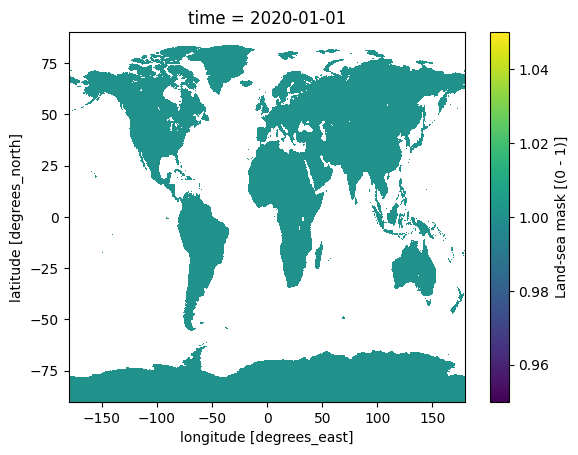

In [10]:
lfile      = f"{ipath}/landmask_era5_global.nc"
varname    = "lsm"
lmask      = xr.open_dataset(lfile)[varname]
lmask      = lmask.where( lmask.values == 1 ) # set 0s to nan
lmask.plot()
landpoints = np.where(lmask==1)[0]
landpoints.shape

In [11]:
lmask_3d = lmask.reindex_like(spi_sig['spi1']['gamma'], method="nearest")

#### Mask barren areas

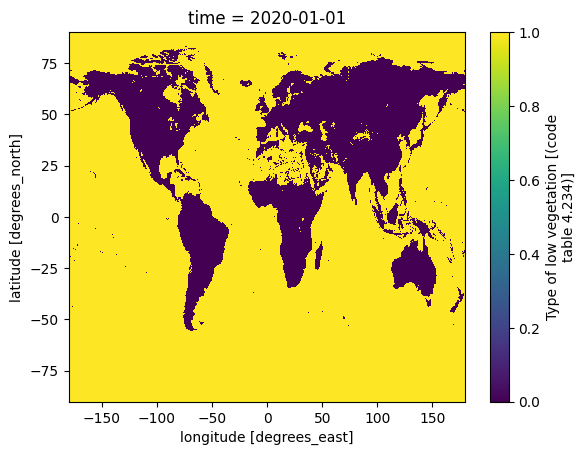

In [12]:
vfile = f"{ipath}/barren_mask.nc"
bmask = xr.open_dataset(vfile)['barren_mask']
#bmask = bmask.where( bmask.values == 1 ) # set 0s to nan
bmask_3d = bmask.reindex_like(spi_sig['spi1']['gamma'], method="nearest")
bmask.plot()

#### Vegetated land only

In [13]:
vlmask = xr.where( (bmask == 0) & (lmask == 1), 1, np.nan)
#vlmask.plot()
vlmask_3d = vlmask.reindex_like(spi_sig['spi1']['gamma'], method="nearest")

## Global evaluation

#### SPI

In [14]:
distribution = spi_configs['distribution'][0]

spi_sig_sum = {}
vspi_sig_sum = {}
for window in spi_configs['windows']:

    spi_sig_sum[f'spi{window}'] = {}
    vspi_sig_sum[f'spi{window}'] = {}

    spi_sig_sum[f'spi{window}'][distribution] = acceptance_rate_monthly_masked(spi_sig[f'spi{window}'][distribution], lmask_3d)
    vspi_sig_sum[f'spi{window}'][distribution] = acceptance_rate_monthly_masked(spi_sig[f'spi{window}'][distribution], vlmask_3d)

#### SPEI

In [15]:
distribution = spei_configs['distribution'][0]

spei_sig_sum = {}
vspei_sig_sum = {}

for window in spei_configs['windows']:

    spei_sig_sum[f'spei{window}'] = {}
    vspei_sig_sum[f'spei{window}'] = {}
    
    spei_sig_sum[f'spei{window}'][distribution] = acceptance_rate_monthly_masked(spei_sig[f'spei{window}'][distribution], lmask_3d)
    vspei_sig_sum[f'spei{window}'][distribution] = acceptance_rate_monthly_masked(spei_sig[f'spei{window}'][distribution], vlmask_3d)

#### Plot

In [16]:
# all land
toplot = np.zeros(shape=(1,14))
i = 0
for window in [1,3,6,12,24,36,48]:
    # all land
    tmp = np.mean(spi_sig_sum[f'spi{window}']['gamma']['significant'])/spi_sig_sum[f'spi{window}']['gamma']['totals'][0]
    toplot[0,i] = tmp
    i += 1
    tmp = np.mean(spei_sig_sum[f'spei{window}']['genlogistic']['significant'])/spei_sig_sum[f'spei{window}']['genlogistic']['totals'][0]
    toplot[0,i] = tmp
    i += 1
# only vegetated land
vtoplot = np.zeros(shape=(1,14))
i = 0
for window in [1,3,6,12,24,36,48]:
    # only vegetated land
    tmp = np.mean(vspi_sig_sum[f'spi{window}']['gamma']['significant'])/vspi_sig_sum[f'spi{window}']['gamma']['totals'][0]
    vtoplot[0,i] = tmp
    i += 1
    tmp = np.mean(vspei_sig_sum[f'spei{window}']['genlogistic']['significant'])/vspei_sig_sum[f'spei{window}']['genlogistic']['totals'][0]
    vtoplot[0,i] = tmp
    i += 1
print(toplot)
print(vtoplot)
print(vtoplot-toplot)

[[0.69154213 0.8970227  0.85249857 0.95631101 0.90599106 0.96787932
  0.93770783 0.97925723 0.94580924 0.97707663 0.93119337 0.95982608
  0.89940402 0.93338338]]
[[0.72127594 0.94821701 0.85089261 0.98014541 0.91465449 0.98661774
  0.94541359 0.98833724 0.94651904 0.97732333 0.92346934 0.95220802
  0.89313563 0.92043673]]
[[ 0.0297338   0.05119431 -0.00160596  0.0238344   0.00866342  0.01873842
   0.00770576  0.00908002  0.00070979  0.0002467  -0.00772403 -0.00761806
  -0.00626839 -0.01294665]]


<Figure size 2000x1000 with 0 Axes>

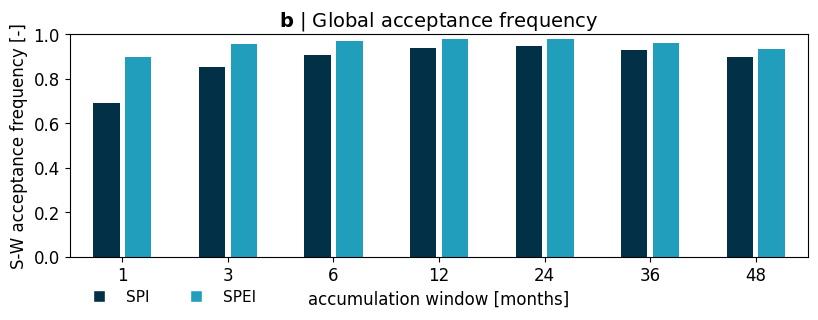

In [80]:
figname="figures/Figure3b.pdf"
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

nrow = 1
ncol = 1
plt.figure(figsize=(20,10)) 
fig, ax1 = plt.subplots(nrow, ncol, sharex=False)
#fig.suptitle(f"Acceptance rate (Shapiro-Wilks test, alpha=0.05)", fontsize=14)
plt.setp([ax1], xticks=[1, 2, 3, 4, 5, 6, 7], xticklabels=['1','3','6','12','24','36','48'])
fig.tight_layout()

col1 = hex2rgb(spi_configs['colors'][0])
col2 = hex2rgb(spei_configs['colors'][0])
mycolors = 7*[col1, col2]
title1 = r"$\bf{" + f"{string.ascii_lowercase[1]}" + "}$"
ax1.set_title(f'{title1} | Global acceptance frequency', fontsize=14, loc='center')
ax1.set_ylim([0,1])
ax1.set_xlim([0.5,7.5])
bar1 = ax1.bar([0.85,1.15,1.85,2.15,2.85,3.15,3.85,4.15,4.85,5.15,5.85,6.15,6.85,7.15], toplot[0,:], width=0.25, 
         color=mycolors, alpha=1) 
ax1.set_xlabel("accumulation window [months]")
ax1.set_ylabel("S-W acceptance frequency [-]")
#for rect in bar1:
#    height = rect.get_height()
#    mytext = ["SPI","SPEI"]
#    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{mytext}', ha='center', va='bottom')
ax.bar_label(ax.containers[0])

fig.tight_layout(pad=1.65)
fig.subplots_adjust(bottom=0.15, hspace=0.5)
plt.gcf().set_size_inches(9, 3)

#fig.legend(fontsize="12", loc ="lower center", ncol=2)
legnames = ["SPI", "SPEI"]
legend_elements = []
for i in range(len(legnames)):
    legend_elements.append(Line2D([0], [0], marker='s', color='w', label=legnames[i], markerfacecolor=[col1, col2][i], markersize=8))
plt.legend(handles=legend_elements, fontsize=11, loc ="lower left", ncol=2, bbox_to_anchor=(0.0,-0.275),
          frameon=False)

plt.savefig(figname, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1, dpi=300,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.show()


### Evaluate SPI quality dependency on Pzero

In [24]:
# Read SPI pzero 
distribution = spi_configs['distribution'][0]

spi_pzero = {}
for window in spi_configs['windows']:

    spi_pzero[f'spi{window}'] = {}

    ifilename     = f"spi/spi{window}/parameter/SPI{window}_{distribution}_global_era5_moda_ref1991to2020_params_updated.nc"
    ifile         = os.path.join(ipath, ifilename)
    tmp           = xr.open_dataset(ifile)['pzero']

    spi_pzero[f'spi{window}'][f'{distribution}'] = tmp

In [32]:
distribution = spi_configs['distribution'][0]

vspi_sig_sum_pzero = {}

for window in spi_configs['windows']:

    vspi_sig_sum_pzero[f'spi{window}'] = {}

    for pzero in np.arange(0.1,0.9,0.1):

        pzero_mask = xr.where(spi_pzero[f'spi{window}'][f'{distribution}'] < pzero, 1, np.nan)
        pvmask = xr.where((pzero_mask == 1) & (vlmask_3d == 1), 1, np.nan)

        vspi_sig_sum_pzero[f'spi{window}'][f'pzero{str(pzero).zfill(1)}'] = {}
        vspi_sig_sum_pzero[f'spi{window}'][f'pzero{str(pzero).zfill(1)}'] = acceptance_rate_monthly_masked(spi_sig[f'spi{window}'][distribution], pvmask)

In [34]:
pvtoplot = np.zeros(shape=(1,7*8))
i = 0
for window in [1,3,6,12,24,36,48]:
    for pzero in np.arange(0.1,0.9,0.1):
        tmp = vspi_sig_sum_pzero[f'spi{window}'][f'pzero{str(pzero).zfill(1)}']['significant']/vspi_sig_sum_pzero[f'spi{window}'][f'pzero{str(pzero).zfill(1)}']['totals']
        pvtoplot[0,i] = np.mean(tmp)
        i += 1
print(pvtoplot)

[[0.76021951 0.74891457 0.74164109 0.73622098 0.73179114 0.72775471
  0.7242694  0.721074   0.86823489 0.86343162 0.86044507 0.85839621
  0.85676424 0.85536941 0.8540457  0.85288486 0.9173335  0.91622001
  0.915632   0.91522398 0.91491141 0.91472786 0.91467466 0.91465385
  0.94553702 0.94541799 0.94541393 0.94541359 0.94541359 0.94541359
  0.94541359 0.94541359 0.94651904 0.94651904 0.94651904 0.94651904
  0.94651904 0.94651904 0.94651904 0.94651904 0.92346934 0.92346934
  0.92346934 0.92346934 0.92346934 0.92346934 0.92346934 0.92346934
  0.89313563 0.89313563 0.89313563 0.89313563 0.89313563 0.89313563
  0.89313563 0.89313563]]


In [47]:
((pvtoplot[0,:-1]-pvtoplot[0,1:]))

array([-1.13049337e-02, -7.27348278e-03, -5.42010663e-03, -4.42984186e-03,
       -4.03642980e-03, -3.48531046e-03, -3.19540282e-03,  1.47160891e-01,
       -4.80326557e-03, -2.98655213e-03, -2.04886628e-03, -1.63196223e-03,
       -1.39483057e-03, -1.32371806e-03, -1.16083243e-03,  6.44486344e-02,
       -1.11348505e-03, -5.88012830e-04, -4.08019832e-04, -3.12572024e-04,
       -1.83544266e-04, -5.32049843e-05, -2.08040847e-05,  3.08831676e-02,
       -1.19026670e-04, -4.06579261e-06, -3.38106335e-07,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.10544401e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.30496912e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.03337135e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

<Figure size 2000x1000 with 0 Axes>

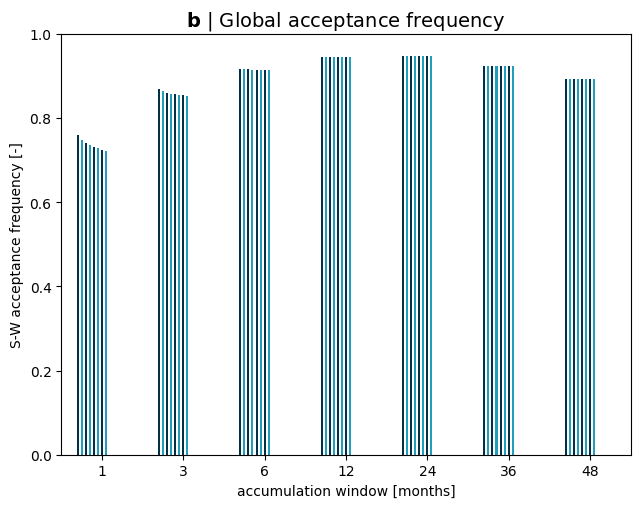

In [45]:
nrow = 1
ncol = 1
plt.figure(figsize=(20,10)) 
fig, ax1 = plt.subplots(nrow, ncol, sharex=False)
#fig.suptitle(f"Acceptance rate (Shapiro-Wilks test, alpha=0.05)", fontsize=14)
plt.setp([ax1], xticks=[1, 2, 3, 4, 5, 6, 7], xticklabels=['1','3','6','12','24','36','48'])
fig.tight_layout()

col1 = hex2rgb(spi_configs['colors'][0])
col2 = hex2rgb(spei_configs['colors'][0])
mycolors = 7*[col1, col2]
title1 = r"$\bf{" + f"{string.ascii_lowercase[1]}" + "}$"
ax1.set_title(f'{title1} | Global acceptance frequency', fontsize=14, loc='center')
ax1.set_ylim([0,1])
ax1.set_xlim([0.5,7.5])
bar1 = ax1.bar([0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05,
                1.70,1.75,1.80,1.85,1.90,1.95,2.00,2.05,
                2.70,2.75,2.80,2.85,2.90,2.95,3.00,3.05,
                3.70,3.75,3.80,3.85,3.90,3.95,4.00,4.05,
                4.70,4.75,4.80,4.85,4.90,4.95,5.00,5.05,
                5.70,5.75,5.80,5.85,5.90,5.95,6.00,6.05,
                6.70,6.75,6.80,6.85,6.90,6.95,7.00,7.05], pvtoplot[0,:], width=0.025, 
         color=mycolors, alpha=1) 
ax1.set_xlabel("accumulation window [months]")
ax1.set_ylabel("S-W acceptance frequency [-]")
#for rect in bar1:
#    height = rect.get_height()
#    mytext = ["SPI","SPEI"]
#    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{mytext}', ha='center', va='bottom')
#ax1.bar_label(ax1.containers[0])

#fig.tight_layout(pad=1.65)
#fig.subplots_adjust(bottom=0.15, hspace=0.5)
#plt.gcf().set_size_inches(9, 3)

#fig.legend(fontsize="12", loc ="lower center", ncol=2)
#legnames = ["SPI", "SPEI"]
#legend_elements = []
#for i in range(len(legnames)):
#    legend_elements.append(Line2D([0], [0], marker='s', color='w', label=legnames[i], markerfacecolor=[col1, col2][i], markersize=8))
#plt.legend(handles=legend_elements, fontsize=11, loc ="lower left", ncol=2, bbox_to_anchor=(0.0,-0.275),
#          frameon=False)

plt.show()


## Global map

In [20]:
# color scheme for map showing number of months non-significant
mylevels     = [0,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1,12.1]
#mycollisthex = ['#bebebe',
#                '#a6cee3','#1f78b4',
#                '#b2df8a','#33a02c',
#                '#fb9a99','#e31a1c',
#                '#fdbf6f','#ff7f00',
#                '#cab2d6','#6a3d9a',
#                '#ffff99','#b15928',]
mycollisthex = ['#000000','#ffffcc', '#f5e9bb', 
                '#ebd3ab', '#e1bd9a', '#d6a88a', 
                '#cb937b', '#bf7e6b', '#b4695d', 
                '#a7544e', '#9b3e40', '#8e2633', '#800026']

In [63]:
window = 3
counter = xr.where(np.isnan(lmask), np.nan, (spei_sig[f'spei{window}']['genlogistic'].sum(axis=(0))) )
#(12-counter).plot(levels=mylevels, colors=mycollisthex)
#plt.title("")

In [64]:
def worldmap_nonsignificant(data_2d, 
                     collist_hex, 
                     levels,
                     legnames,
                     figname="figures/test.png",
                     latlines=[-30,30], plot_latlines=False, mytitle=""):

    plt.figure(figsize=(9, 4));
    ax = plt.axes(projection=ccrs.Robinson(), frameon=False);
    ax.coastlines(color='black', lw=0.25)
    data_2d.plot(ax=ax, transform=ccrs.PlateCarree(),
                              x='lon', y='lat',
                              add_colorbar=False,
                              colors=collist_hex,
                              levels=levels,
                              vmin=0, vmax=12.1)
    ax.set_title(mytitle)

    # horizontal lat-lines
    if plot_latlines:
        geodetic = ccrs.Geodetic()
        robinson = ccrs.Robinson()
        for ilat in latlines:
            ilon_1, ilat_1 = robinson.transform_point(-179, ilat, geodetic)
            ilon_2, ilat_2 = robinson.transform_point(+179, ilat, geodetic)
            ax.plot([ilon_1, ilon_2], [ilat_1, ilat_2], color='grey', linewidth=0.5, transform=robinson, linestyle=':')

    ax.set_extent([-170000, 180, -50, 82]) # (x0, x1, y0, y1)

    legend_elements = []
    for i in range(len(legnames))[1:]:
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=legnames[i], markerfacecolor=hex2rgb(collist_hex[i][1:]), markersize=8))
    plt.legend(handles=legend_elements, fontsize="8", loc ="lower left", ncol=1)

    plt.tight_layout()
    plt.savefig(figname, format=None, metadata=None,
                bbox_inches=None, pad_inches=0.1, dpi=300,
                facecolor='auto', edgecolor='auto',
                backend=None)
    plt.show()

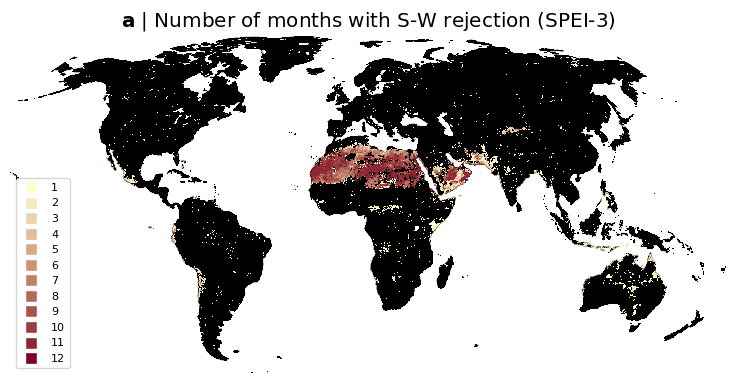

In [65]:
title1 = r"$\bf{" + f"{string.ascii_lowercase[0]}" + "}$"
worldmap_nonsignificant(12-counter, mycollisthex, mylevels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                        mytitle=f'{title1} | Number of months with S-W rejection (SPEI-3)',
                       figname="figures/Figure3a.pdf")